In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset

import os
import random
from PIL import Image

## THE DATA

#### Define Data Preprocessing and Augmentation

Here, we will define transformations to resize, normalize, and augment the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),   # Crop the image randomly
    transforms.RandomHorizontalFlip(),   # Flip the image randomly
    transforms.ToTensor(),               # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

#### Load Data

Now, we'll load the data from the coffee_images folder, and apply the transformations:

In [3]:
dataset = datasets.ImageFolder(root='coffe_arabica_datasets', transform=transform)

#### Select Random Subset

To select only 500 random images from each class, we'll have to split the data accordingly.

Some images may be corrupt. The routine below will ignore any corrupted image.

In [4]:
def safe_pil_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except:
        print(f"Could not read {path}. Skipping.")
        return None


In [5]:
class CoffeeLeafDataset(Dataset):
    def __init__(self, root_dir, num_samples_per_class=5000, transform=None):
        self.samples = []
        self.class_to_idx = {}
        self.root_dir = root_dir
        self.transform = transform

        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            # Ignore non-directory files
            if not os.path.isdir(class_path):
                continue

            self.class_to_idx[class_dir] = label
            all_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            selected_files = random.sample(all_files, num_samples_per_class)
            for file in selected_files:
                file_path = os.path.join(class_path, file)
                self.samples.append((file_path, label))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = safe_pil_loader(path)
        if image is not None and self.transform:
            image = self.transform(image)
        return image, label


In [6]:
dataset = CoffeeLeafDataset(root_dir='coffe_arabica_datasets', num_samples_per_class=5000, transform=transform)

#### Split Data

Now, we'll split the subset into training, validation, and test sets.

In [7]:
total_length = len(dataset)
train_size = int(0.8 * total_length)
remaining_size = total_length - train_size
val_size = test_size = remaining_size // 2

train_data, rest_data = random_split(dataset, [train_size, remaining_size])
val_data, test_data = random_split(rest_data, [val_size, test_size])


In [8]:
print(f"Train Data: {len(train_data)}, Val Data: {len(val_data)}, Test Data: {len(test_data)}")

Train Data: 20000, Val Data: 2500, Test Data: 2500


#### Create Data Loaders

Finally, we'll create Data Loaders for the training, validation, and test sets

In [40]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

#When defining a validation loader, it's typical to set shuffle=False. The reason for this is that you generally want to evaluate the model on the entire validation set and compute metrics like loss and accuracy 
# consistently across different runs or different epochs. If you shuffle the validation data, you might introduce some randomness into those metrics, which could make it more challenging to interpret how the model 
# is performing over time.
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# For the test loader we do shuffle=True so that we can sample small batches of images randomly.
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


## THE MODEL

This architecture consists of three convolutional layers, each followed by a ReLU activation function and a max-pooling layer. Then, there are three fully connected layers to reduce the dimensions and make the final classification into one of the 5 classes.

In [10]:
import torch.nn as nn

class CoffeeLeafClassifier(nn.Module):
    def __init__(self):
        super(CoffeeLeafClassifier, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 30 * 30, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, 5) # 5 classes
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = self.fc_layers(x)
        return x


### Model Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

In [13]:
# Model, Loss, and Optimizer
model = CoffeeLeafClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Training Loop

# Define patience and best validation loss
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # Move to GPU
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) # Move to GPU
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping due to lack of improvement in validation loss.")
            break

Epoch 1/20, Train Loss: 0.6612141923189163
Validation Loss: 0.3983365263365492, Accuracy: 83.24%
Epoch 2/20, Train Loss: 0.39400146371126177
Validation Loss: 0.2255955103171777, Accuracy: 91.76%
Epoch 3/20, Train Loss: 0.30393311961740255
Validation Loss: 0.2651473737875872, Accuracy: 92.44%
Epoch 4/20, Train Loss: 0.2819264309287071
Validation Loss: 0.21009967092990497, Accuracy: 92.8%
Epoch 5/20, Train Loss: 0.24241613955795766
Validation Loss: 0.15735307056456804, Accuracy: 94.8%
Epoch 6/20, Train Loss: 0.21955733101069927
Validation Loss: 0.19137569582915004, Accuracy: 94.2%
Epoch 7/20, Train Loss: 0.19559216959178446
Validation Loss: 0.12243746768070173, Accuracy: 95.72%
Epoch 8/20, Train Loss: 0.21399525225013494
Validation Loss: 0.1536935420730446, Accuracy: 95.2%
Epoch 9/20, Train Loss: 0.20702119196653365
Validation Loss: 0.16731054374735943, Accuracy: 94.64%
Epoch 10/20, Train Loss: 0.20854319101721047
Validation Loss: 0.139039051153143, Accuracy: 95.16%
Epoch 11/20, Train Lo

## METRICS

#### Accuracy

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')


Accuracy: 94.72%


#### F1 and confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [17]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_mat)

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# You can also print a full classification report
print('Classification Report:')
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[500   0   6   1   7]
 [  0 501   0   0   0]
 [ 28   0 446  15   2]
 [ 11   0  36 406  28]
 [  1   0   0   0 512]]
F1 Score: 0.9452815737800676
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       514
           1       1.00      1.00      1.00       501
           2       0.91      0.91      0.91       491
           3       0.96      0.84      0.90       481
           4       0.93      1.00      0.96       513

    accuracy                           0.95      2500
   macro avg       0.95      0.94      0.94      2500
weighted avg       0.95      0.95      0.95      2500



#### Save the model

In [18]:
# Specify the folder and filename
model_folder = 'coffee_classifier'
model_path = os.path.join(model_folder, 'coffee_leaf_classifier.pth')

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Save the entire model
torch.save(model, model_path)

print(f"Model saved to {model_path}")


Model saved to coffee_classifier\coffee_leaf_classifier.pth


## INFERENCE

In [19]:
class_to_idx = dataset.class_to_idx

In [20]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]


In [21]:
class_names

['Cerscospora', 'Healthy', 'Miner', 'Phoma', 'Rust']

In [22]:
model_path = os.path.join('coffee_classifier', 'coffee_leaf_classifier.pth')
model = torch.load(model_path)
model.eval()


CoffeeLeafClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=115200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [85]:
from PIL import Image
from torchvision import transforms

image_path = './coffe_arabica_datasets/Phoma/1 (344).jpg'
image_path = './coffe_arabica_datasets/Cerscospora/4 (365).jpg'
image_path = './coffe_arabica_datasets/Miner/1 (10497).jpg'
image_path = './coffe_arabica_datasets/Rust/1 (366).jpg'

image = Image.open(image_path)

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Adjust mean and std if necessary
])

# Apply the transformations to the image
image_tensor = transform(image)

# Add a batch dimension (since models expect a batch of images, not a single image)
image_tensor = image_tensor.unsqueeze(0)

# Move to the same device as the model (if using CUDA)
image_tensor = image_tensor.to(device)

# Pass the image through the model
output = model(image_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, 1)

print(f"The predicted class for the image is: {predicted_class.item()}")

predicted_class_name = class_names[predicted_class.item()]
print(f"The predicted class for the image is: {predicted_class_name}")


The predicted class for the image is: 2
The predicted class for the image is: Miner


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

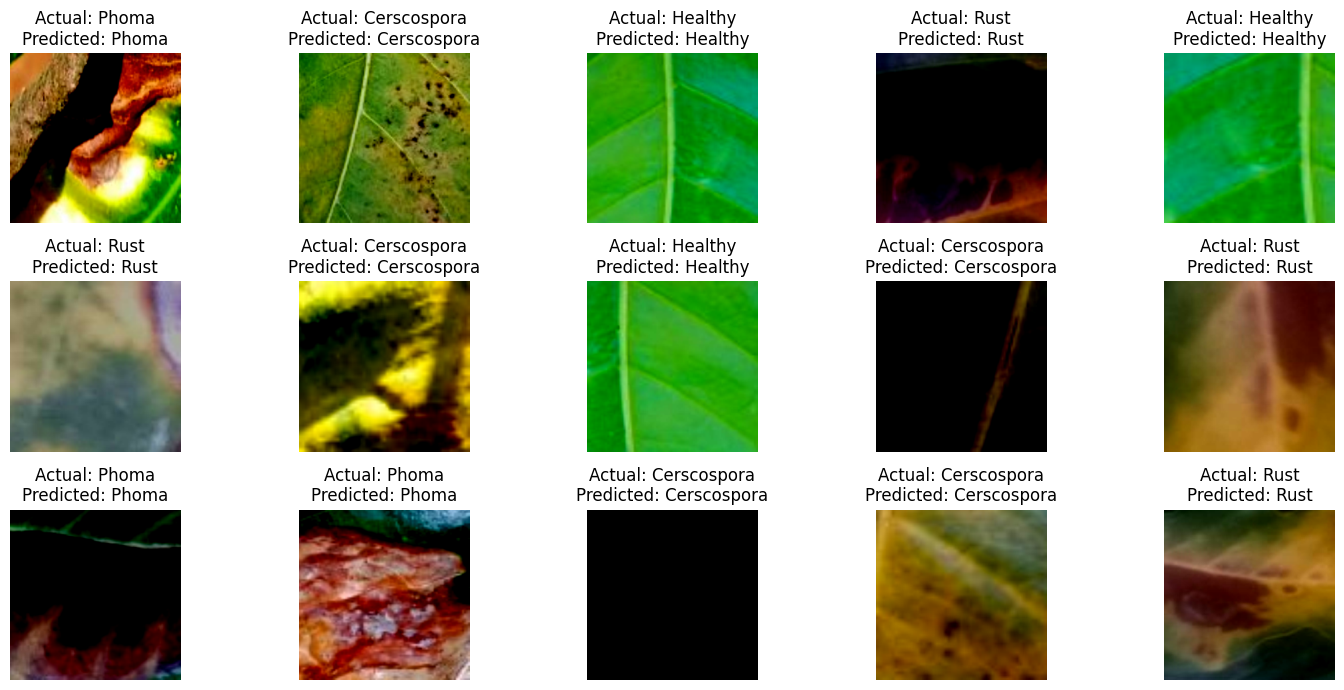

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch

sample_size = 15
img_per_row = 5
rows = sample_size // img_per_row 

# Select  random images from test_loader
images, labels = next(iter(test_loader))
images, labels = images[:sample_size], labels[:sample_size]

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Convert labels and predictions to numpy
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

# Visualization
fig, axs = plt.subplots(rows, img_per_row, figsize=(15, (sample_size // 2)))

for i, ax in enumerate(axs.flat):
    image = images[i].cpu().numpy()  # Remove squeeze if image already has shape (3, H, W)
    image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, 3)
    actual_class = idx_to_class[labels[i]]
    predicted_class = idx_to_class[preds[i]]

    ax.imshow(image)  # No need for colormap since it's a color image
    ax.set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    ax.axis('off')

plt.tight_layout()
plt.show()